# Introduction

This notebook contains an analysis of the simulation `Drift`. Two species were separated and trapped in two different corrals (circular cage of radius 10 $\mu$m). The diffusion coefficient is $D = 0.1$ $\mu$m$^2/$s. The drift velocity was 0.3 $\mu$m/s in the upward direction.

In [1]:
#!pip install pandas seaborn scikit-learn lmfit mahotas imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions.functions import TE_MSD,Michalet,set_size,pool_data
from sklearn.cluster import KMeans
import matplotlib as mpl
import seaborn as sns
import random

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=10
maxframe=100000
rsquared_threshold=-100

# Exact trajectories

We can bypass the tracking section by using Smoldyn's `listmol2` function which exports to a text file the position of all the particles in the system at all desired time steps. 

In [2]:
#Preprocess the Smoldyn exact trajectories
data = pd.read_csv('Drift/output.txt', sep=" ", header=None)
data.columns = ["iteration", "useless1", "useless2", "POSITION_X","POSITION_Y","TRACK_ID"]
data[["POSITION_X","POSITION_Y","TRACK_ID"]].to_csv('Drift/temp.csv',index=None)

In [3]:
files = ["Drift/temp.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=2,display_id=False)

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  10 , maxframe =  100000 , R2 threshold =  -100
Fit option:  2
Reading filenames in  ['Drift/temp.csv'] ...
Analysis for Drift/temp.csv ...
196  tracks were kept out of  181497 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.


We can immediately recover the real label for each track from the spatial position of each track (whether its in corral 1 or 2). 

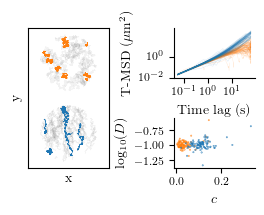

In [4]:
Y = list(df['y'].values)
X = list(df['x'].values)
label = np.zeros(len(Y))
for k in range(len(Y)):
    y = Y[k]
    if y[0] < 50:
        label[k] = 0
    else:
        label[k] = 1

c1 = 'tab:orange'
c2 = 'tab:blue'

#Create RGB array for trajectory plot
label_rgb = [c1 if x==1 else c2 for x in label]
df['Real_Label'] = label

#Generate LaTex-compatible plot
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(15))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = label_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    

trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
logD = df['D'].values
c = df['c'].values
features.scatter(c,logD,color=label_rgb,s=0.1)
features.set_ylabel(r'log$_{10}(D)$')
features.set_xlabel(r'$c$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=label_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Drift/Plots/drift_exact_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

Compute the TE-MSD and ensemble variance...
Done. The TE-MSD and associated variance have been generated.


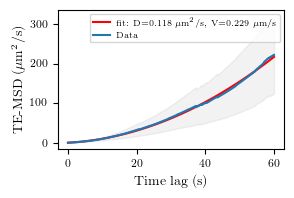

In [5]:
MSDdrift = list(df['MSD'][(df['Real_Label']==0)].values)
temsd,var,timelag = TE_MSD(MSDdrift,plot=False)

from scipy.optimize import curve_fit

def drift_model(timelag, D, V):
    return(4*D*timelag+(V**2)*(timelag**2))

popt, pcov = curve_fit(drift_model, timelag, temsd)


mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.8)
ax = fig.add_subplot(grid[0,0])
ax.plot(timelag, drift_model(timelag, *popt), 'r-',label=r'fit: D=%5.3f $\mu$m$^2/$s, V=%5.3f $\mu$m/s' % tuple(popt))
ax.plot(timelag,temsd,label='Data')
ax.fill_between(timelag,[msd+np.sqrt(var) for msd,var in zip(temsd,var)], [msd-np.sqrt(var) for msd,var in zip(temsd,var)],color='gray',alpha=0.1)
#ax.set_xlim(0.05,30)
ax.set_xlabel('Time lag (s)')
ax.set_ylabel(r'TE-MSD ($\mu$m$^2/$s)')
plt.legend(fontsize=6)
fig.savefig('Drift/Plots/drift_exact_ensemble_msd_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()
#Michalet(MSDfast,cutoff=1) #CAREFUL THIS IS SLOW DUE TO THE VERY LONG TRACKS

# Simulated movie

In [6]:
minframe=12
files = ["Drift/movie/tracks.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option="thirty_percent")

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  12 , maxframe =  100000 , R2 threshold =  -100
Fit option:  thirty_percent
Reading filenames in  ['Drift/movie/tracks.csv'] ...
Analysis for Drift/movie/tracks.csv ...
4697  tracks were kept out of  164148 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.


In [7]:
display(df.describe())
N = 4697
samp1 = df.sample(N)

,alpha,D,c,R2,N
count,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000
mean,0.704947,-1.128554,0.176889,0.289833,30.866085
std,0.254577,0.310696,0.111634,1.272003,20.069284
min,0.100000,-2.471687,0.001071,-13.277422,12.000000
25%,0.544031,-1.300449,0.097206,0.359503,17.000000
50%,0.717627,-1.110920,0.155733,0.710871,25.000000
75%,0.882383,-0.927088,0.235509,0.881183,39.000000
max,1.695081,-0.001144,0.732730,0.999322,217.000000


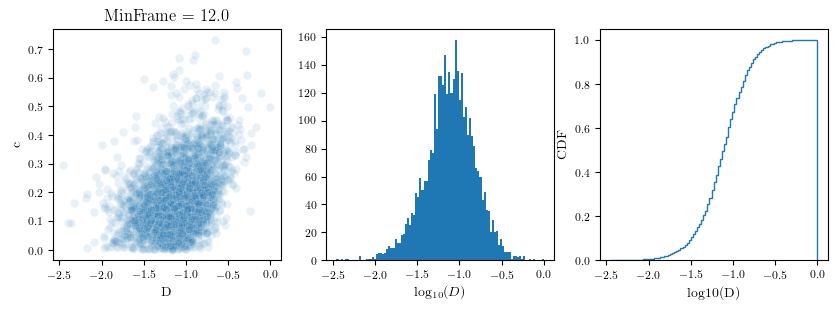

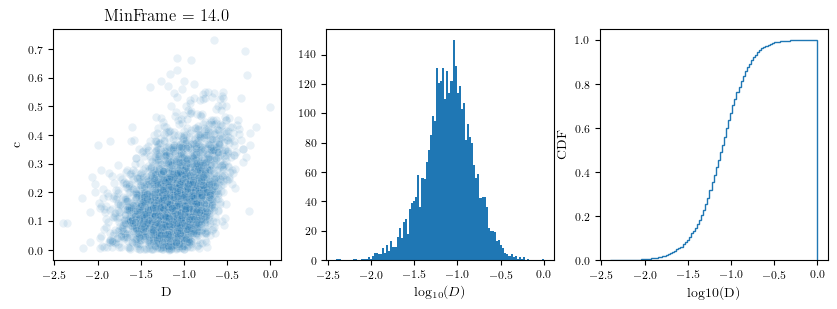

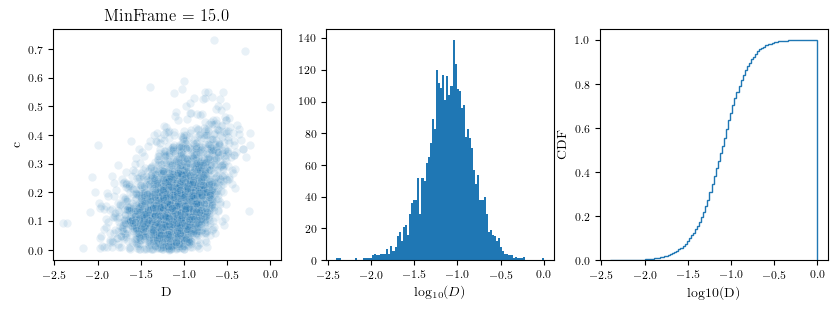

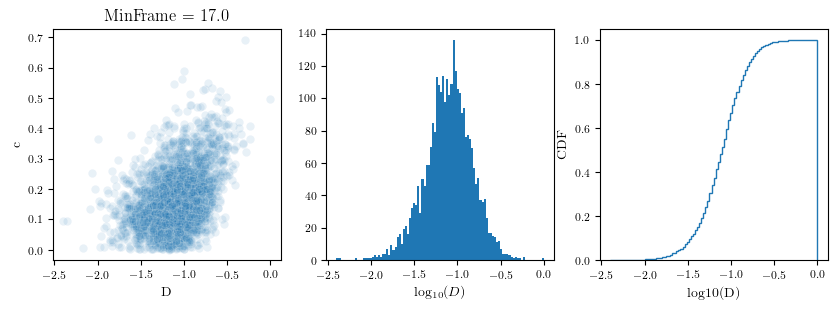

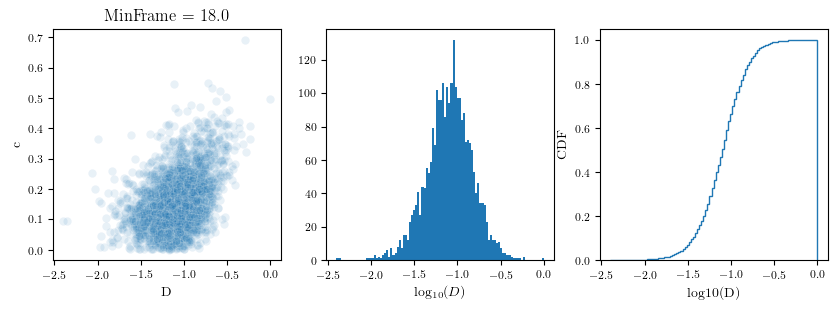

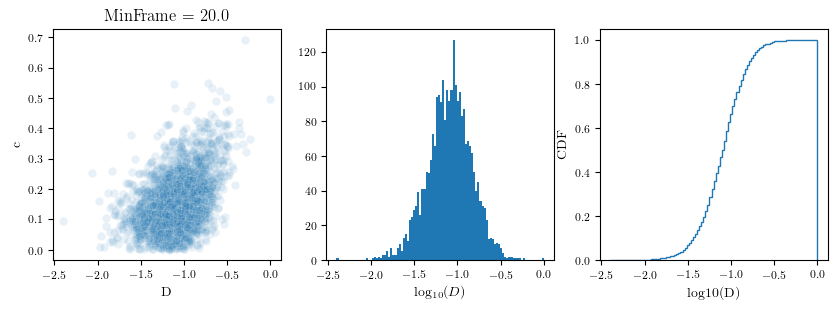

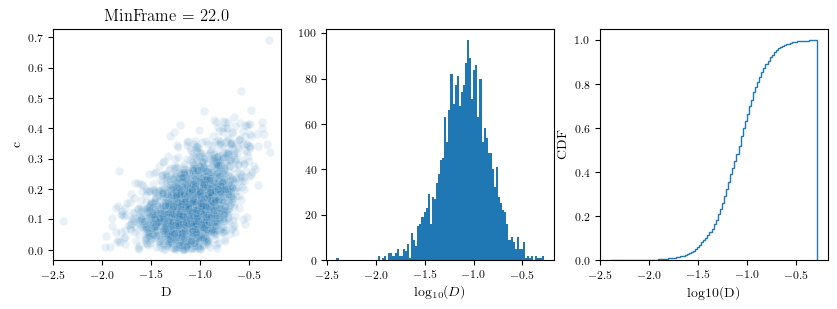

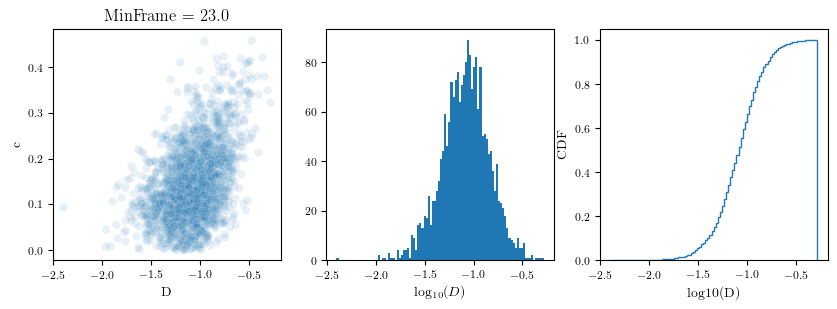

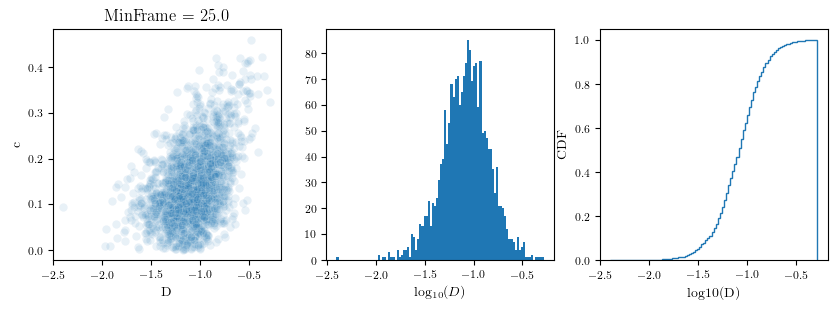

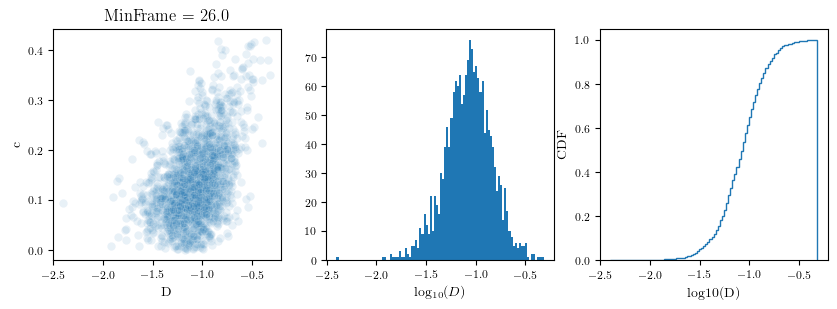

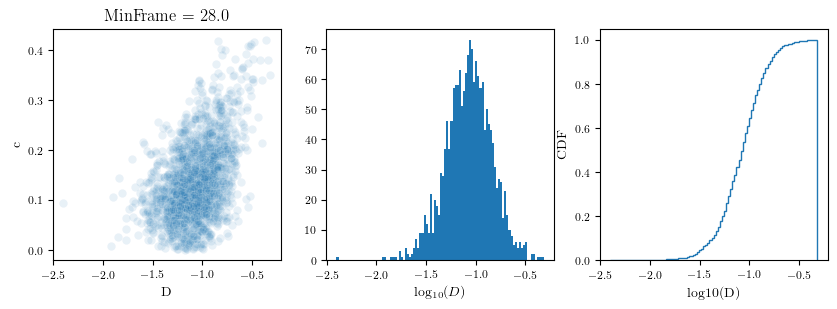

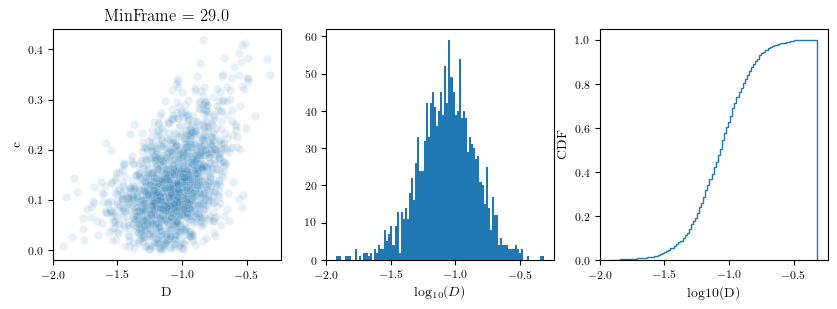

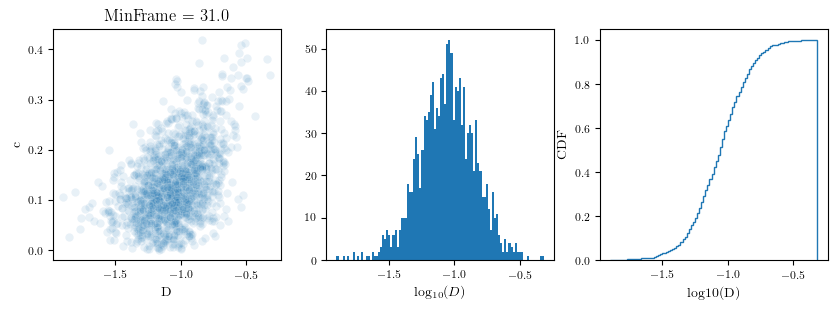

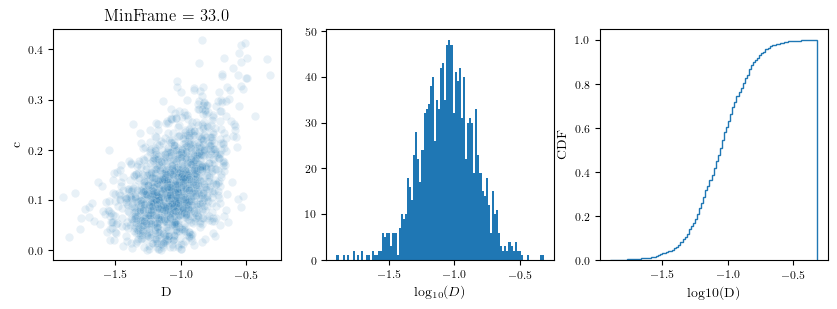

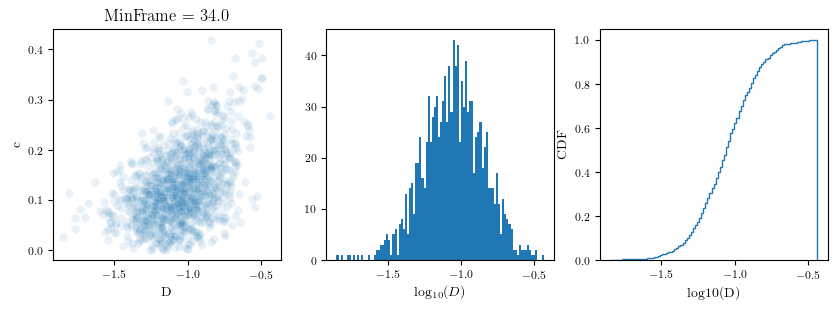

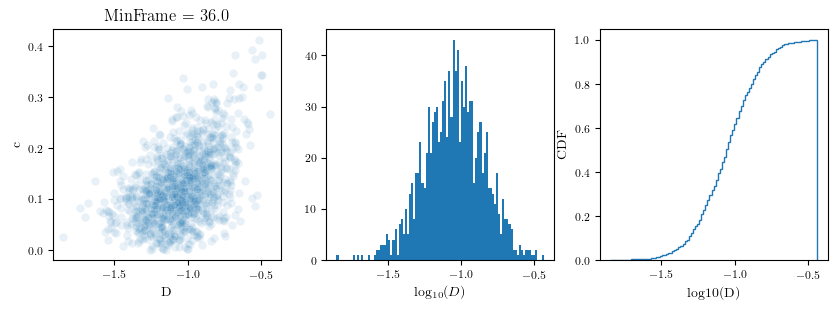

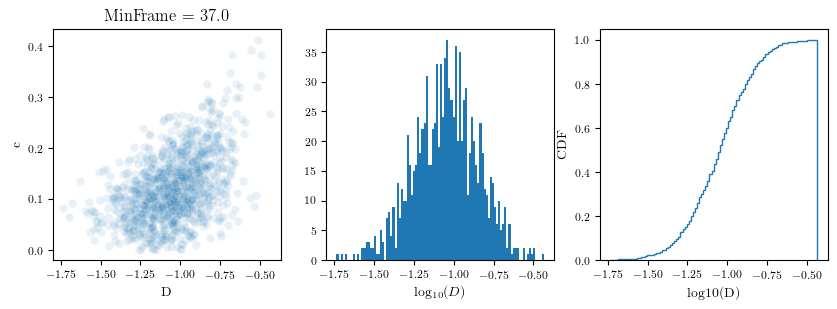

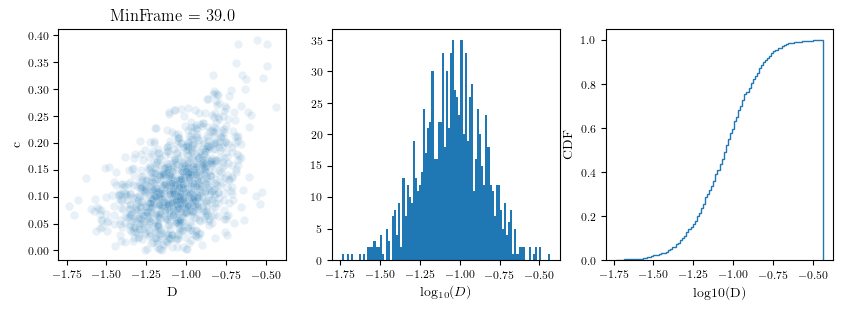

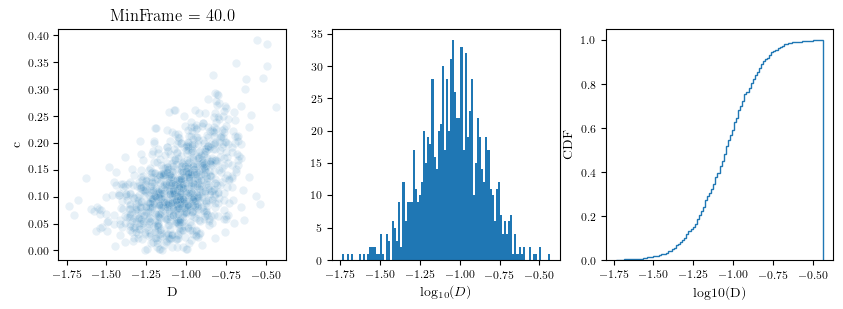

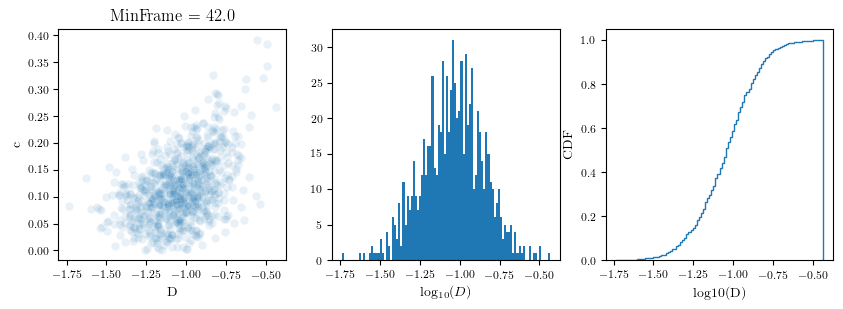

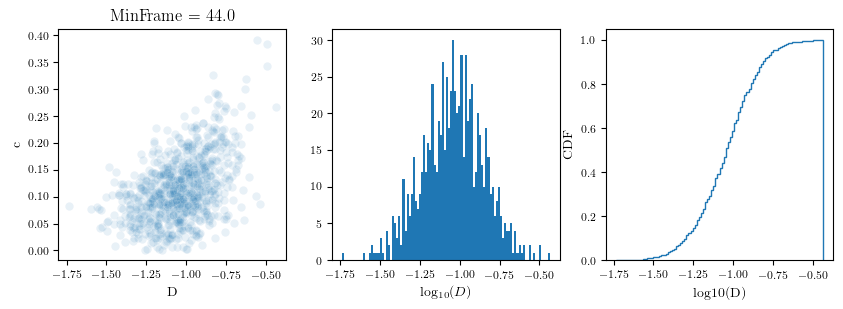

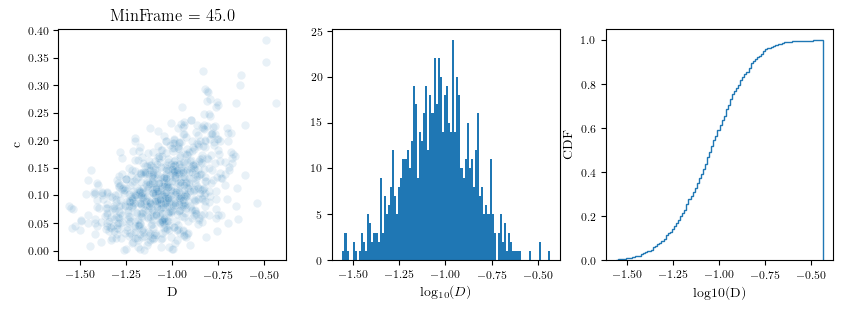

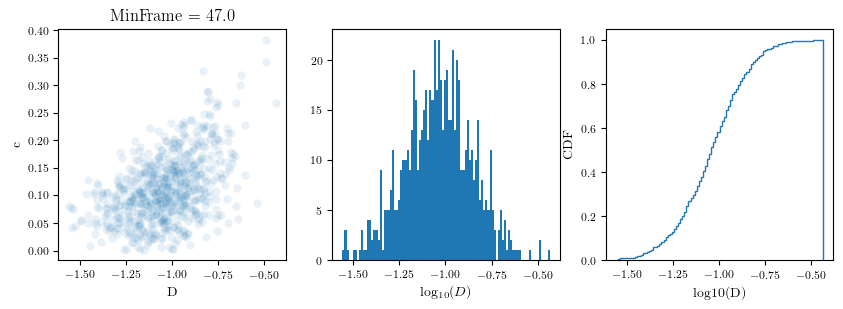

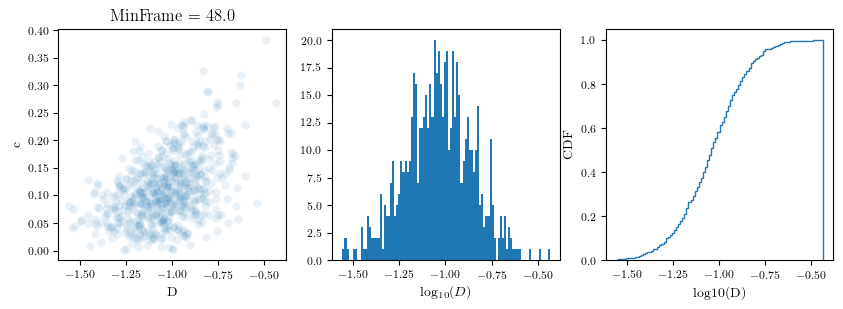

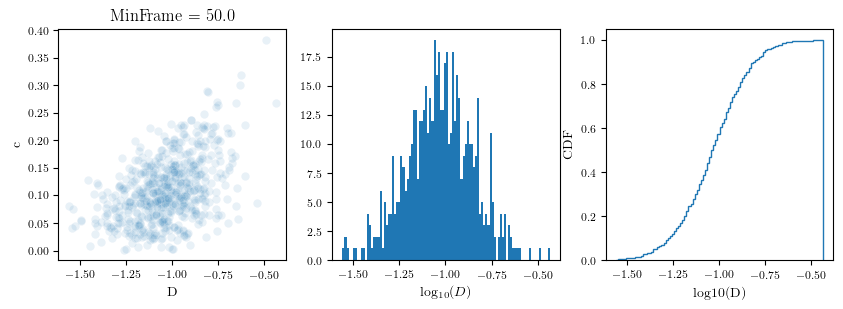

In [8]:
N = np.linspace(minframe,50,25)
for n in N:
    temp1 = samp1[(samp1['N']>n) & (samp1['R2']>0.)]
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    
    sns.scatterplot(x='D',y='c',data=temp1,ax=ax[0],alpha=0.1)
    ax[0].set_title('MinFrame = '+str(round(n)))
    
    ax[1].hist(temp1['D'],bins=100)
    ax[1].set_xlabel(r'log$_{10}(D)$')
    
    ax[2].hist(temp1['D'],bins=100,density=True, histtype='step',cumulative=True)
    ax[2].set_ylabel('CDF')
    ax[2].set_xlabel('log10(D)')

    plt.show()

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


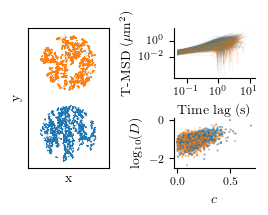

In [13]:
minframe = 20
r2 = 0.
df = samp1[(samp1['N']>=minframe) & (samp1['R2']>r2)]

Y = list(df['y'].values)
X = list(df['x'].values)
label = np.zeros(len(Y))
for k in range(len(Y)):
    y = Y[k]
    if y[0] < 70:
        label[k] = 0
    else:
        label[k] = 1

c1 = 'tab:orange'
c2 = 'tab:blue'

#Create RGB array for trajectory plot
label_rgb = [c1 if x==1 else c2 for x in label]
df['Real_Label'] = label

#Generate LaTex-compatible plot
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(2000))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = label_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    

trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
c = df['c'].values
logD = df['D'].values
features.scatter(c,logD,color=label_rgb,s=0.1)
features.set_ylabel(r'log$_{10}(D)$')
features.set_xlabel(r'$c$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=label_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Drift/Plots/drift_movie_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

Compute the TE-MSD and ensemble variance...
Done. The TE-MSD and associated variance have been generated.


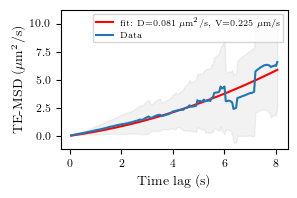

In [10]:
MSDdrift = list(df['MSD'][(df['Real_Label']==0)].values)
temsd,var,timelag = TE_MSD(MSDdrift,plot=False)

from scipy.optimize import curve_fit

def drift_model(timelag, D, V):
    return(4*D*timelag+(V**2)*(timelag**2))

popt, pcov = curve_fit(drift_model, timelag, temsd)


mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(1, 1, wspace=0.8, hspace=0.8)
ax = fig.add_subplot(grid[0,0])
ax.plot(timelag, drift_model(timelag, *popt), 'r-',label=r'fit: D=%5.3f $\mu$m$^2/$s, V=%5.3f $\mu$m/s' % tuple(popt))
ax.plot(timelag,temsd,label='Data')
ax.fill_between(timelag,[msd+np.sqrt(var) for msd,var in zip(temsd,var)], [msd-np.sqrt(var) for msd,var in zip(temsd,var)],color='gray',alpha=0.1)
#ax.set_xlim(0.05,30)
ax.set_xlabel('Time lag (s)')
ax.set_ylabel(r'TE-MSD ($\mu$m$^2/$s)')
plt.legend(fontsize=6)
fig.savefig('Drift/Plots/drift_movie_ensemble_msd_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()
#Michalet(MSDfast,cutoff=1) #CAREFUL THIS IS SLOW DUE TO THE VERY LONG TRACKS

# Calibrate the Gaussian mixture

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=1000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=500)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


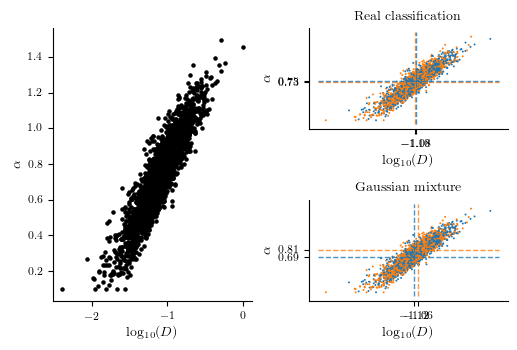

The total error is  47.47591522157996  % or  52.52408477842004 %


In [12]:
mpl.rcParams.update(mpl.rcParamsDefault)

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==1 else c2 for x in label]
        
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(2, 4, wspace=0.8, hspace=0.7,bottom=0.2,left=0.2)
ax0 = fig.add_subplot(grid[0:2, 0:2])
ax1 = fig.add_subplot(grid[0, 2:4])
ax2 = fig.add_subplot(grid[1, 2:4])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=label_rgb,s=2,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['Real_Label']==1)].mean()
meanalpha0 = df['alpha'][(df['Real_Label']==0)].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['Real_Label']==1)].mean()
meanD0 = df['D'][(df['Real_Label']==0)].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Real classification',fontsize=10)

ax2.scatter(D,alpha,c=labels_GM_rgb,s=2,edgecolors='w',linewidths=0.001)
ax2.set_xlabel(r'log$_{10}(D)$')
ax2.set_ylabel(r'$\alpha$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

xmin, xmax = ax2.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==0)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==1)].mean()
ax2.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax2.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax2.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax2.get_ylim()
meanD1 = df['D'][(df['GM_Label']==0)].mean()
meanD0 = df['D'][(df['GM_Label']==1)].mean()
ax2.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax2.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax2.set_xticks([round(meanD1,2),round(meanD0,2)])
ax2.set_title('Gaussian mixture',fontsize=10)

fig.savefig('Drift/Plots/drift_movie_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

error = []
for lab1,lab2 in zip(label,labels_GM):
    if lab1==lab2:
        error.append(0)
    else:
        error.append(1)
total_error = sum(error)
print("The total error is ",total_error*100/len(error)," % or ",100-total_error*100/len(error),'%')
    